In [373]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [374]:
def f(x):
  return 3*x**2 - 4*x + 5

In [375]:
f(0)

5

In [376]:
f(math.sqrt(3))

7.0717967697244895

In [377]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

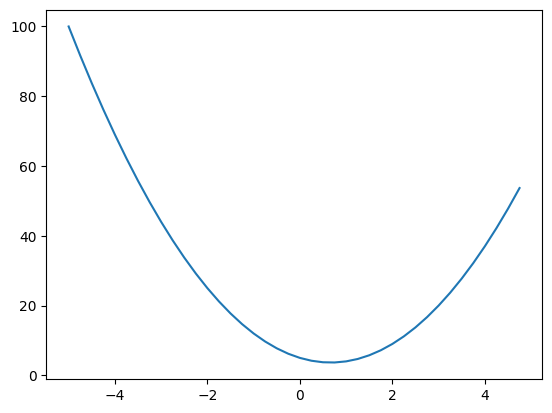

In [378]:
plt.plot(xs, ys)
plt.show()

In [379]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [380]:
h = 1e-6
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [381]:
h = 1e-6
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [382]:
h = 1e-6
x = 2 / 3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [383]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [384]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  3.9999969999999996
slope:  -3.000000000419334


In [385]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.000002
slope:  2.000000000279556


In [386]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.000000999999999
slope:  0.9999999992515995


In [387]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other):  # other - self
    return (-self) + other

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [388]:
a = Value(2.0); b = Value(4.0)
4 - a

Value(data=2.0)

In [389]:
# a / b
# a * (1/b)
# a * (b**-1)

In [390]:
a + b

Value(data=6.0)

In [391]:
a * b

Value(data=8.0)

In [392]:
c = Value(7.0, label='c')
d = a * b + c; d.label = 'd'

In [393]:
d._prev

{Value(data=7.0), Value(data=8.0)}

In [394]:
d._op

'+'

In [395]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

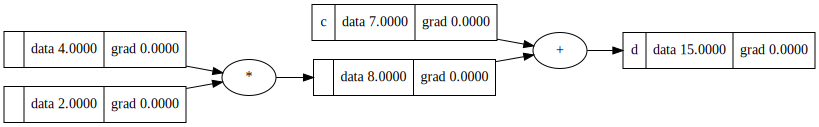

In [396]:
draw_dot(d)

In [397]:
e = a * b; e.label = 'e'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

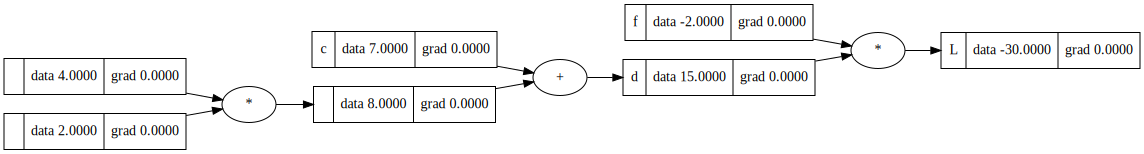

In [398]:
draw_dot(L)

In [399]:
h = 0.001

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

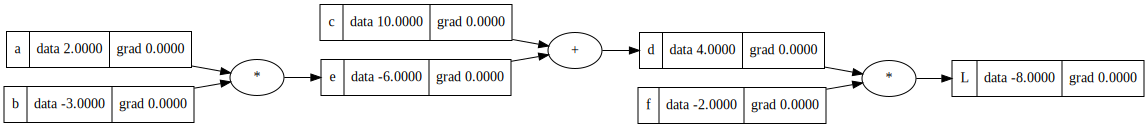

In [400]:
draw_dot(L)

In [401]:
# dL/dL
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  print((L2 - L1) / h)

lol()

1.000000000139778


In [402]:
L.grad = 1.0

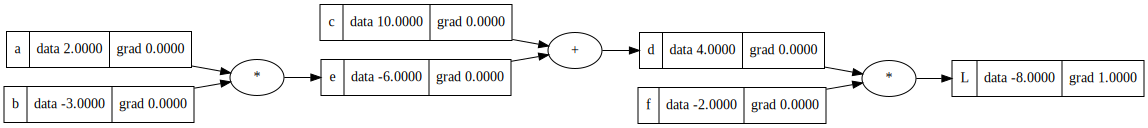

In [403]:
draw_dot(L)

In [404]:
# dL/dd
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-2.000000000279556


In [405]:
d.grad = -2.0

In [406]:
# dL/df
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

3.9999999996709334


In [407]:
f.grad = 4.0

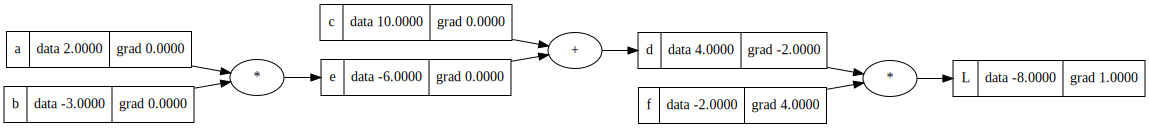

In [408]:
draw_dot(L)

In [409]:
# dL/de
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  e.data += h
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-2.000000000279556


In [410]:
e.grad = -2.0

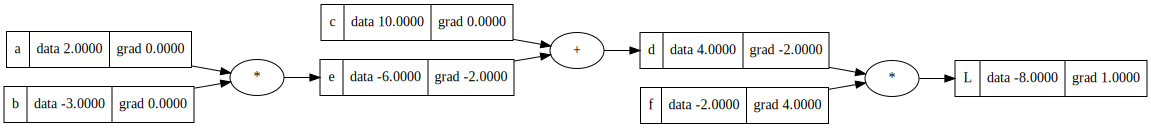

In [411]:
draw_dot(L)

In [412]:
# dL/dc
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data += h
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.999999998503199


In [413]:
c.grad = -2.0

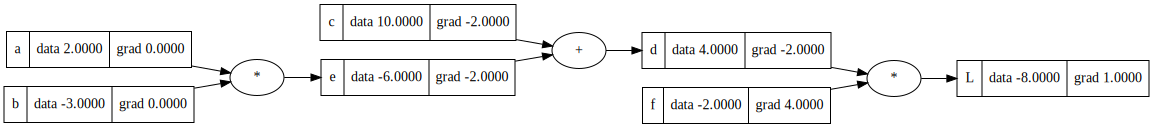

In [414]:
draw_dot(L)

In [415]:
# dL/da
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  a.data += h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

6.000000000838668


In [416]:
a.grad = 6.0

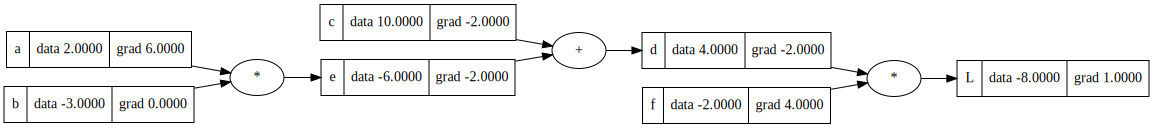

In [417]:
draw_dot(L)

In [418]:
# dL/db
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-4.000000000559112


In [419]:
b.data = -2.0

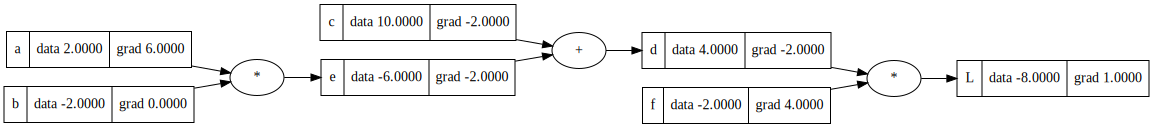

In [420]:
draw_dot(L)

In [421]:
print(f'a = {a}')
print(f'b = {b}')
print(f'c = {c}')
print(f'd = {d}')
print(f'e = {e}')
print(f'f = {f}')
print(f'L = {L}')

a = Value(data=2.0)
b = Value(data=-2.0)
c = Value(data=10.0)
d = Value(data=4.0)
e = Value(data=-6.0)
f = Value(data=-2.0)
L = Value(data=-8.0)


In [422]:
# var = var - (learning_rate) * dL/dvar
# var = var - (learning_rate) * var.grad
lr = 0.001
a.data -= lr * a.grad
b.data -= lr * a.grad
c.data -= lr * c.grad
d.data -= lr * d.grad
e.data -= lr * e.grad
f.data -= lr * f.grad

In [423]:
print(f'a = {a}')
print(f'b = {b}')
print(f'c = {c}')
print(f'd = {d}')
print(f'e = {e}')
print(f'f = {f}')
print(f'L = {L}')

a = Value(data=1.994)
b = Value(data=-2.006)
c = Value(data=10.002)
d = Value(data=4.002)
e = Value(data=-5.998)
f = Value(data=-2.004)
L = Value(data=-8.0)


In [424]:
# One forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-12.028080144000002


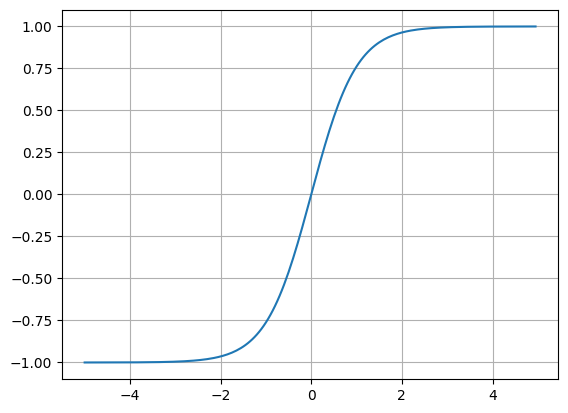

In [425]:
plt.plot(np.arange(-5, 5, 0.05), np.tanh(np.arange(-5, 5, 0.05))); plt.grid();

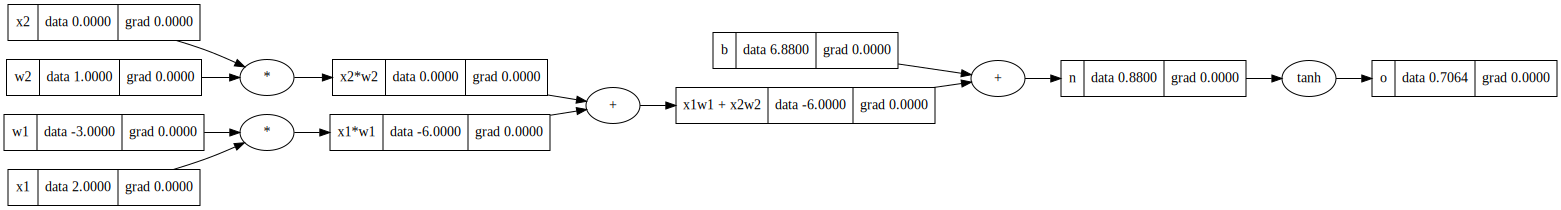

In [426]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [427]:
o.grad = 1.0

In [428]:
n.grad = 0.5

In [429]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [430]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [431]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [432]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

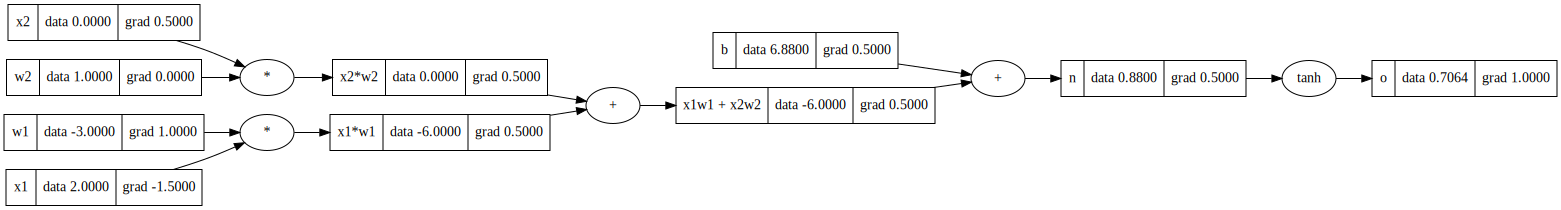

In [433]:
draw_dot(o)

In [434]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ^ 2 = 1 - o**2
1 - o.data ** 2

0.5009717437695084

In [435]:
## Calling _backward on all the nodes during backprop
o.grad = 1.0
o._backward()

In [436]:
n._backward()

In [437]:
b._backward()

In [438]:
x1w1x2w2._backward()

In [439]:
x2w2._backward()

In [440]:
x1w1._backward()

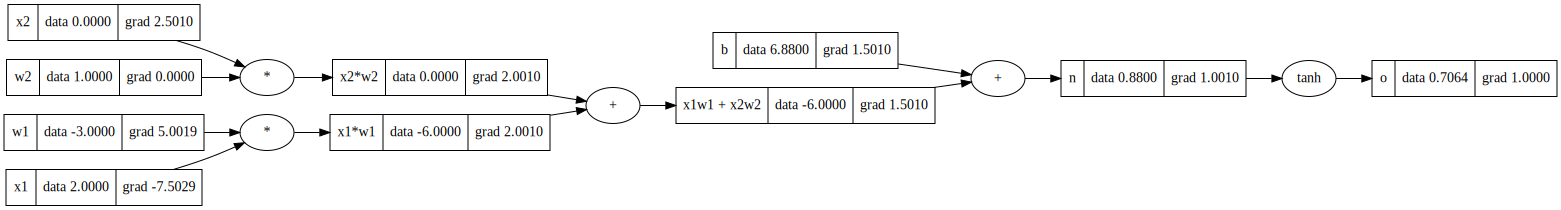

In [441]:
draw_dot(o)

In [442]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.88),
 Value(data=0.8799999999999999),
 Value(data=0.7064193203972352)]

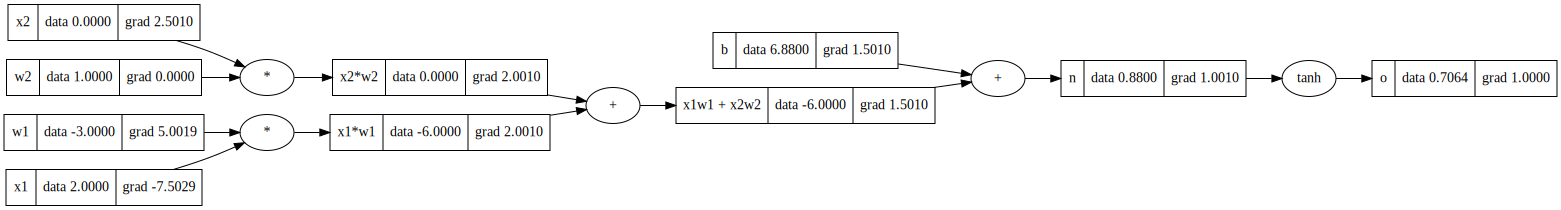

In [443]:
draw_dot(o)

In [444]:
o.grad = 1.0

topo = []
visited = set()
def build_top(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

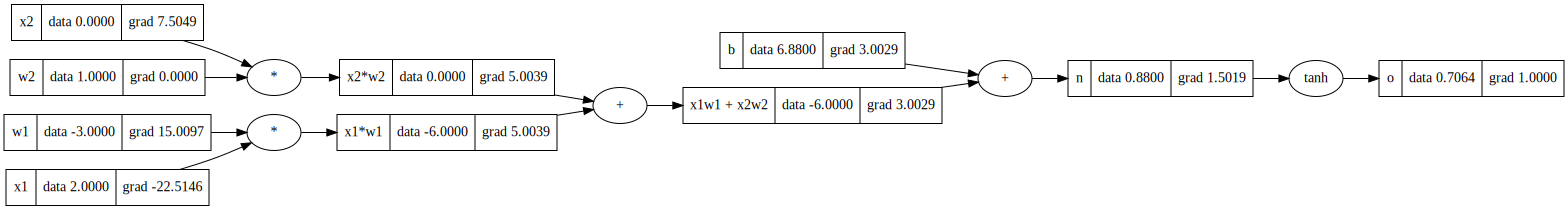

In [445]:
draw_dot(o)

In [446]:
o.backward()

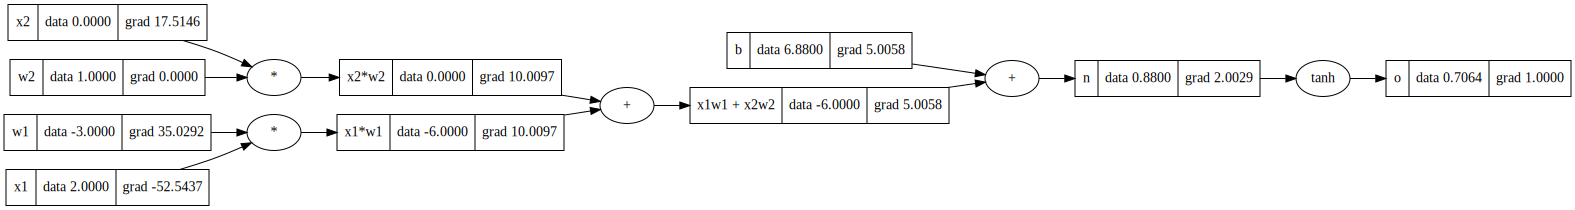

In [447]:
draw_dot(o)

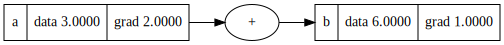

In [448]:
# Dealing with a bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

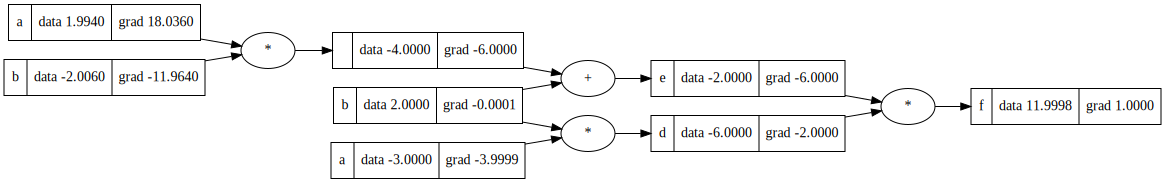

In [449]:
a = Value(-3.0, label='a')
b = Value(2.0, label='b')
d = a * b; d.label = 'd'
e = e + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

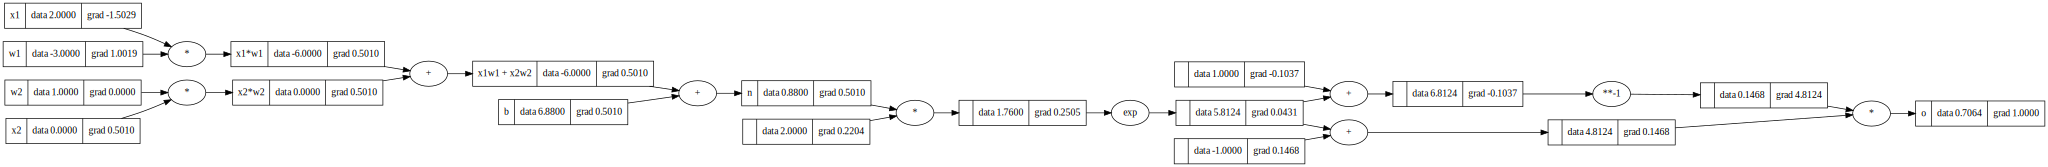

In [450]:
## Breaking up the tanh
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# --------
o.label = 'o'
o.backward()
draw_dot(o)

In [451]:
# Doing the same thing using PyTorch
import torch

x1 = torch.tensor([2.0])
x1.requires_grad = True

x2 = torch.tensor([0.0])
x2.requires_grad = True

w1 = torch.tensor([-3.0])
w1.requires_grad = True

w2 = torch.tensor([1.0])
w2.requires_grad = True

b = torch.tensor([6.88])
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('-----------')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7064193487167358
-----------
-1.5029150247573853
0.5009716749191284
1.0019433498382568
0.0


In [465]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in list(zip(self.w, x))), self.b)
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # return [p for neuron in self.neurons for p in neuron.parameters()]
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)

    return params

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [466]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.993355261353323)

In [468]:
n.parameters(), len(n.parameters())

([Value(data=-0.6282890518976236),
  Value(data=-0.7532984350446654),
  Value(data=0.6645988097657984)],
 3)

In [469]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.998420016182163),
 Value(data=0.9950060821669575),
 Value(data=-0.9945293106987215)]

In [470]:
nin = 3; nouts = [4, 4, 1]
[nin] + nouts

[3, 4, 4, 1]

In [537]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8772961682139697)

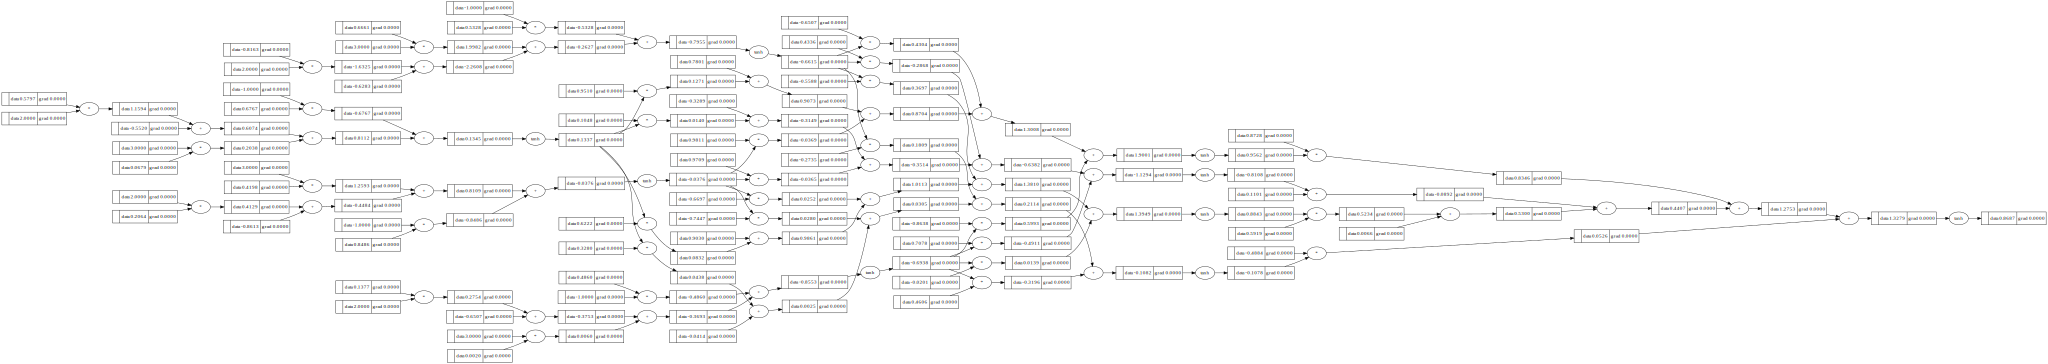

In [531]:
draw_dot(n(x))

In [473]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, 1.0, -1.0]

In [474]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.1403331401122139),
 Value(data=0.30702457176282255),
 Value(data=-0.08885672378330776),
 Value(data=0.030545789573833877)]

In [475]:
loss = sum(((ygt - yout)**2 for ygt, yout in zip(ys, y_pred)), 0) / len(ys)
loss

Value(data=1.173743482629398)

In [476]:
loss.backward()

In [480]:
n.layers[0].neurons[0].w[0].data

-0.01636735865120399

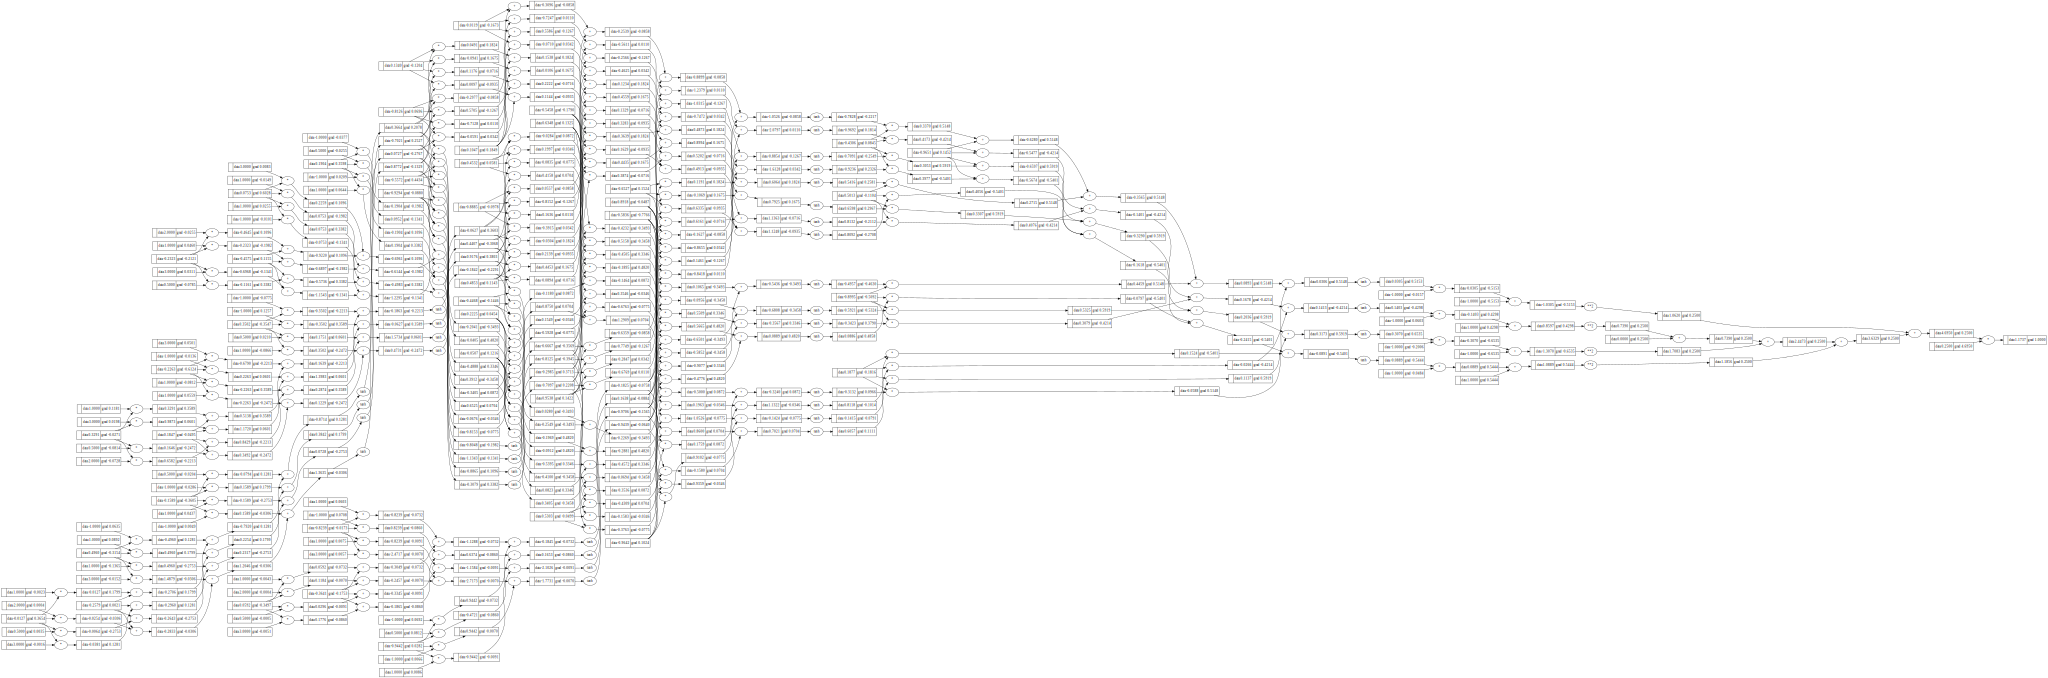

In [478]:
draw_dot(loss)

In [479]:
lr = 1e-2
for p in n.parameters():
  p.data -= lr * p.grad

In [481]:
y_pred = [n(x) for x in xs]
loss = sum(((ygt - yout)**2 for ygt, yout in zip(ys, y_pred)), 0) / len(ys)
loss

Value(data=1.1443094903270483)

In [527]:
loss.backward()
lr = 1e-2
for p in n.parameters():
  p.data -= lr * p.grad

In [528]:
y_pred = [n(x) for x in xs]
loss = sum(((ygt - yout)**2 for ygt, yout in zip(ys, y_pred)), 0) / len(ys)
loss

Value(data=0.0027894114698884436)

In [529]:
n.parameters()

[Value(data=-0.6626206031573157),
 Value(data=0.8382702210686296),
 Value(data=0.48725961357805964),
 Value(data=-0.35880633765535047),
 Value(data=0.22918030866428032),
 Value(data=0.6426092968311335),
 Value(data=0.9058167587027743),
 Value(data=0.1144655799332597),
 Value(data=0.46738681072259175),
 Value(data=-0.647142602694885),
 Value(data=-0.34280049010220137),
 Value(data=-0.4002336271602868),
 Value(data=0.8803863974713138),
 Value(data=-1.0730028274166348),
 Value(data=-1.0144655823074915),
 Value(data=0.08132642423425453),
 Value(data=-0.9745303626831326),
 Value(data=-0.6964529571318855),
 Value(data=0.6707462853213185),
 Value(data=1.0272192118525623),
 Value(data=0.3674062115954672),
 Value(data=0.4159266438223237),
 Value(data=0.32592403443040835),
 Value(data=-0.26428070622792926),
 Value(data=-0.997425557074295),
 Value(data=-0.24362317847517298),
 Value(data=-1.25005840131573),
 Value(data=-0.34998651568729733),
 Value(data=0.4831503134886671),
 Value(data=0.609067184

In [592]:
num_epochs = 10000
lr = 1e-2

loss = 0

for epoch in range(num_epochs):
  # forward pass
  y_pred = [n(x) for x in xs]
  loss = sum(((ygt - yout)**2 for ygt, yout in zip(ys, y_pred)), 0) / len(ys)

  # zero grad
  for p in n.parameters():
    p.grad = 0.0

  # backward pass
  loss.backward()

  # update parameters
  for p in n.parameters():
    p.data -= lr * p.grad

  print(f'Epoch: {epoch + 1} | Loss: {loss}')

print('-----')
# print('Parameters after training for 10 epochs: \n')
print(n.parameters())

Streaming output truncated to the last 5000 lines.
Epoch: 5005 | Loss: Value(data=0.00019509421274673487)
Epoch: 5006 | Loss: Value(data=0.00019507845097915848)
Epoch: 5007 | Loss: Value(data=0.00019506269168693876)
Epoch: 5008 | Loss: Value(data=0.00019504693486949845)
Epoch: 5009 | Loss: Value(data=0.00019503118052626315)
Epoch: 5010 | Loss: Value(data=0.0001950154286566569)
Epoch: 5011 | Loss: Value(data=0.000194999679260102)
Epoch: 5012 | Loss: Value(data=0.00019498393233602707)
Epoch: 5013 | Loss: Value(data=0.0001949681878838559)
Epoch: 5014 | Loss: Value(data=0.00019495244590301116)
Epoch: 5015 | Loss: Value(data=0.00019493670639292467)
Epoch: 5016 | Loss: Value(data=0.00019492096935301445)
Epoch: 5017 | Loss: Value(data=0.00019490523478270876)
Epoch: 5018 | Loss: Value(data=0.00019488950268143625)
Epoch: 5019 | Loss: Value(data=0.00019487377304862043)
Epoch: 5020 | Loss: Value(data=0.00019485804588368954)
Epoch: 5021 | Loss: Value(data=0.00019484232118606733)
Epoch: 5022 | Loss

In [593]:
y_pred

[Value(data=0.9835277455718925),
 Value(data=-0.9971795604184158),
 Value(data=0.9923288145620287),
 Value(data=-0.9852932351129032)]